In [2]:
%matplotlib inline
import sys, os, time
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import math

# import cv2
import scipy.signal
from skimage.transform import rotate

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import fiona
import shapely.geometry
import rasterio
import rasterio.features

import torch
import torch.nn

In [3]:
with rasterio.open("../test_inference_50.tif") as f:
    data = f.read().squeeze()
    data_transform = f.transform
    data_crs = f.crs
print(np.unique(data))
data -= 1
print(np.unique(data))
data.shape

[0 1]
[  0 255]


(7586, 6110)

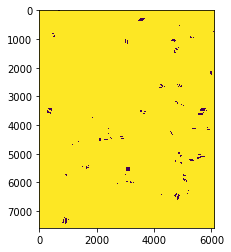

In [4]:
plt.imshow(data)

In [5]:
def generate_rectangle(aspect_ratio, height, width, rotation, min_pixel=100):
    redo = True
    img = np.zeros((width, height), dtype=np.uint8)
    while redo == True:
        start_x = np.random.randint(width//2)
        start_y = np.random.randint(height//2)

        # Chooses from short side...
        short_side = np.random.randint(height//3)
        long_side  = short_side * aspect_ratio

        end_y = int(start_y + short_side)
        end_x = int(start_x + long_side)

        # Get center
        center_x = (max(start_x,end_x) - min(start_x, end_x)) / 2
        center_y = (max(start_y,end_y) - min(start_y, end_y)) / 2

        rec = cv2.rectangle(img, (start_x, start_y), (end_x, end_y), (10,10,10), -1)
        img = rotate(image=img, angle=rotation)

        area = short_side * long_side
        percent_area = area / (height*width) 
        
        # Make sure there's no empty images (at least 100 pixels are in img)
        if np.count_nonzero(img) < (min_pixel) or percent_area < 0.1:
            # reset
            redo = True
            img = np.zeros((width, height), dtype=np.uint8)
        else:
            redo = False
                    
    return img / img.sum()

In [6]:
aspect_ratio = lambda: np.random.normal(loc=9.07, scale=1.71)

In [7]:
pos_kernels = []
for i in range(36):
    rect = generate_rectangle(aspect_ratio(), 432, 288, np.random.randint(360), 800)
    pos_kernels.append(rect)
    
neg_kernels = []
for pos_kernel in pos_kernels:
    neg_kernel = 1 - pos_kernel.copy()
    neg_kernel = neg_kernel / (neg_kernel.sum() + 0.00001)
    neg_kernels.append(neg_kernel)

NameError: name 'cv2' is not defined

In [ ]:
for pos_kernel in neg_kernels:
    plt.figure(figsize=(4,4))
    plt.imshow(pos_kernel)
    plt.show()
    plt.close()

# plt.figure(figsize=(4,4))
# plt.imshow(pos_kernels[1])
# plt.show()
# plt.close()

In [ ]:
!pip install descartes

In [ ]:
import shapely.geometry
import rasterio
import rasterio.features
import geopandas as gpd

def post_processing(input_fn, area_thresh, aspect_ratio_thresh):
    def get_side_lengths(shape):
        def distance(pt1, pt2):
            return math.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
        xs, ys = shape.boundary.xy
        pts = list(zip(xs, ys))
        lengths = []
        for i in range(len(pts)-1):
            lengths.append(distance(pts[i], pts[i+1]))
        assert len(lengths) == 4
        return sorted(lengths)

    data = None
    with rasterio.open(input_fn) as f:
        data = f.read().squeeze()
        data_transform = f.transform
        data_crs = f.crs
        
    mask = data == 2
    polygons = list(
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) in enumerate(rasterio.features.shapes(data, mask=mask, transform=data_transform))
    )

    print(len(polygons))
    
    # Filter by shape
    shape_area_threshold = area_thresh

    polygons_filtered_by_size = []
    for polygon in polygons:
        shape = shapely.geometry.shape(polygon["geometry"])

        if shape.area > shape_area_threshold:
            polygons_filtered_by_size.append(polygon)
    
    print(len(polygons_filtered_by_size))
            
    # Filter by aspect ratio
    aspect_ratio_threshold = aspect_ratio_thresh

    polygons_filtered_by_aspect_ratio = []
    poly_list = []
    for polygon in polygons_filtered_by_size:
        shape = shapely.geometry.shape(polygon["geometry"])


        side_lengths = get_side_lengths(shape.minimum_rotated_rectangle)    
        short_length = min(side_lengths)
        long_length = max(side_lengths)

        aspect_ratio = long_length / short_length
        if aspect_ratio > aspect_ratio_threshold:
            polygons_filtered_by_aspect_ratio.append(polygon)
            poly_list.append(shape)

    print(len(polygons_filtered_by_aspect_ratio))
            
    polys_gdf = gpd.GeoDataFrame(geometry=poly_list)
    list_of_polygons = []
    polygons_filtered_by_aspect_ratio_and_size = []

    for i in range(len(polys_gdf)):
        plt.close('all')
        fig, ax = plt.subplots()
        ax.axis('off')
        polys_gdf.loc[[i],'geometry'].plot(ax = ax)
        fig.canvas.draw()
        arr = np.array(fig.canvas.renderer.buffer_rgba())[:,:,0]
        arr[arr == 255] = 0
        arr[arr == 31] = 1
        list_of_polygons.append(arr)
        polygons_filtered_by_aspect_ratio_and_size.append(polygons_filtered_by_aspect_ratio[i])
    
    return list_of_polygons, polygons_filtered_by_aspect_ratio_and_size, data_crs

In [ ]:
lop,polygons_filtered_by_aspect_ratio_and_size,crs = post_processing("../landcover_scripts/temp_123/test_inference_ae_even_3807537/ae_tuned_model_even_05_0.21.tif", 525, 4)


In [ ]:
lop[0].shape

In [ ]:
plt.imshow(lop[0])

In [ ]:
test = lop[0]
test[np.newaxis, np.newaxis, :, :].shape

In [ ]:
data_torch = torch.from_numpy(data[np.newaxis, np.newaxis, :, :].astype(np.float16)).to("cuda")
data_torch.require_grad = False
data_torch.shape

In [8]:
pos_kernels = np.array(pos_kernels)
pos_kernels = pos_kernels[:,np.newaxis,:,:]
pos_kernels = torch.from_numpy(pos_kernels.astype(np.float16)).to("cuda")
pos_kernels.require_grad = False
pos_kernels.shape

IndexError: too many indices for array

In [9]:
neg_kernels = np.array(neg_kernels)
neg_kernels = neg_kernels[:,np.newaxis,:,:]
neg_kernels = torch.from_numpy(neg_kernels.astype(np.float16)).to("cuda")
neg_kernels.require_grad = False
neg_kernels.shape

NameError: name 'neg_kernels' is not defined

In [15]:
%%time
outputs_pos = torch.nn.functional.conv2d(data_torch, pos_kernels, padding=25)

with torch.no_grad():
    outputs_pos = outputs_pos.cpu().numpy().astype(np.float32)
outputs_pos = np.rollaxis(outputs_pos.squeeze(), 0, 3)
torch.cuda.empty_cache()
outputs_pos.shape

CPU times: user 5.87 s, sys: 3.47 s, total: 9.34 s
Wall time: 9.33 s


(7622, 6122, 36)

In [16]:
%%time
outputs_neg = torch.nn.functional.conv2d(1-data_torch, neg_kernels, padding=25)

with torch.no_grad():
    outputs_neg = outputs_neg.cpu().numpy().astype(np.float32)
outputs_neg = np.rollaxis(outputs_neg.squeeze(), 0, 3)
torch.cuda.empty_cache()
outputs_neg.shape

CPU times: user 5.11 s, sys: 6.47 s, total: 11.6 s
Wall time: 11.6 s


(7622, 6122, 36)

In [17]:
data_small = data[2000:3500,1000:2500]
outputs_pos_small = outputs_pos[2000:3500,1000:2500]
outputs_neg_small = outputs_neg[2000:3500,1000:2500]

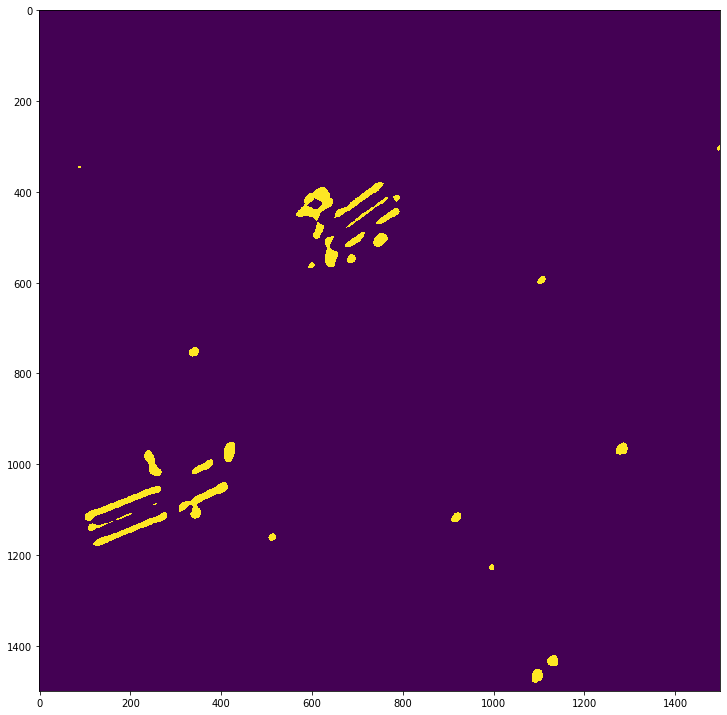

In [35]:
plt.figure(figsize=(12.2, 15.4))
plt.imshow((outputs_pos_small.sum(axis=2) + outputs_neg_small.sum(axis=2)) > 38, vmin=0)
#plt.colorbar()
plt.show()
plt.close()

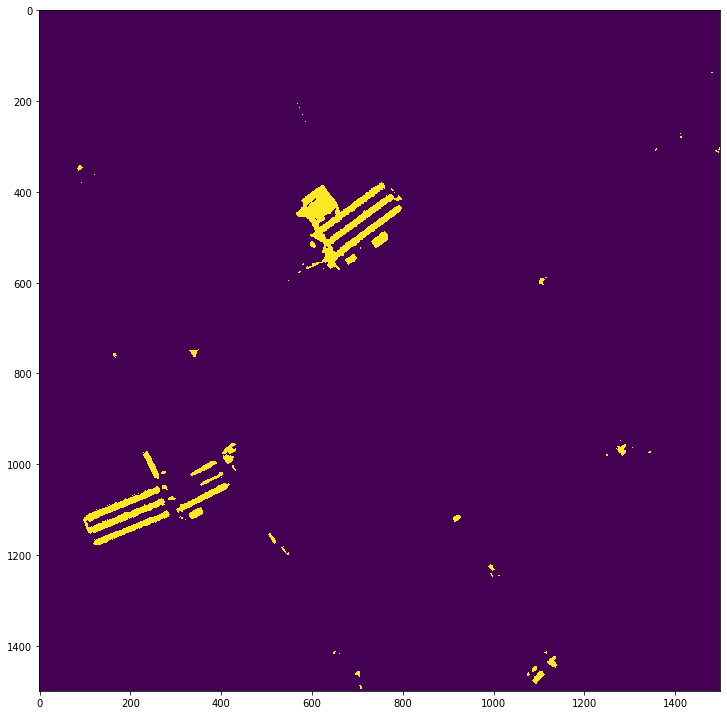

In [27]:
plt.figure(figsize=(1
                    2.2, 15.4))
plt.imshow(data_small)
plt.show()
plt.close()